In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np


In [33]:
all_attrs_map = {
    0: '5_o_Clock_Shadow',
    1: 'Arched_Eyebrows',
    2: 'Attractive',
    3: 'Bags_Under_Eyes',
    4: 'Bald',
    5: 'Bangs',
    6: 'Big_Lips',
    7: 'Big_Nose',
    8: 'Black_Hair',
    9: 'Blond_Hair',
    10: 'Blurry',
    11: 'Brown_Hair',
    12: 'Bushy_Eyebrows',
    13: 'Chubby',
    14: 'Double_Chin',
    15: 'Eyeglasses',
    16: 'Goatee',
    17: 'Gray_Hair',
    18: 'Heavy_Makeup',
    19: 'High_Cheekbones',
    20: 'Male',
    21: 'Mouth_Slightly_Open',
    22: 'Mustache',
    23: 'Narrow_Eyes',
    24: 'No_Beard',
    25: 'Oval_Face',
    26: 'Pale_Skin',
    27: 'Pointy_Nose',
    28: 'Receding_Hairline',
    29: 'Rosy_Cheeks',
    30: 'Sideburns',
    31: 'Smiling',
    32: 'Straight_Hair',
    33: 'Wavy_Hair',
    34: 'Wearing_Earrings',
    35: 'Wearing_Hat',
    36: 'Wearing_Lipstick',
    37: 'Wearing_Necklace',
    38: 'Wearing_Necktie',
    39: 'Young'
}

selected_attrs = ['Old','Young','Female','Male','Black_Hair','Blond_Hair','Brown_Hair']

In [34]:
crop_size = 178
image_size = 128

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(crop_size),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

attr2id_map = {name: idx for idx, name in all_attrs_map.items()}

class CelebA(Dataset):

    def __init__(self, root_dir, selected_attrs, transform):
        self.root_dir = root_dir
        self.selected_attrs = selected_attrs
        self.transform = transform

        self.img_dir = self.root_dir / 'images'
        self.attr_path = self.root_dir / 'list_attr_celeba.txt'

        self.images = []
        self.labels = []

        self.preprocess()

    def preprocess(self):
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        lines = lines[2:]  # actual images with label information

        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []  # [Old, Young, Female, Male, Black_Hair, Blond_Hair, Brown_Hair]
            for attr in self.selected_attrs:
                if attr == 'Old':
                    label.append(1 if values[39] != '1' else 0)  # If not young then old
                elif attr == 'Female':
                    label.append(1 if values[20] != '1' else 0)  # If not male then female
                else:
                    label.append(1 if values[attr2id_map[attr]] == '1' else 0)

            if np.sum(label) == 0:
                continue

            self.images.append(filename)
            self.labels.append(label)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        image = Image.open(self.img_dir / str(image)).convert('RGB')
        label = torch.FloatTensor(label)

        return self.transform(image), label

    def __len__(self):
        return len(self.images)

In [35]:
data_dir = Path('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/celeba')

dataset = CelebA(data_dir, selected_attrs, transform)
print(len(dataset.images))

202599


In [36]:
dataset.images[0], dataset.labels[0]

('000001.jpg', [0, 1, 1, 0, 0, 0, 1])

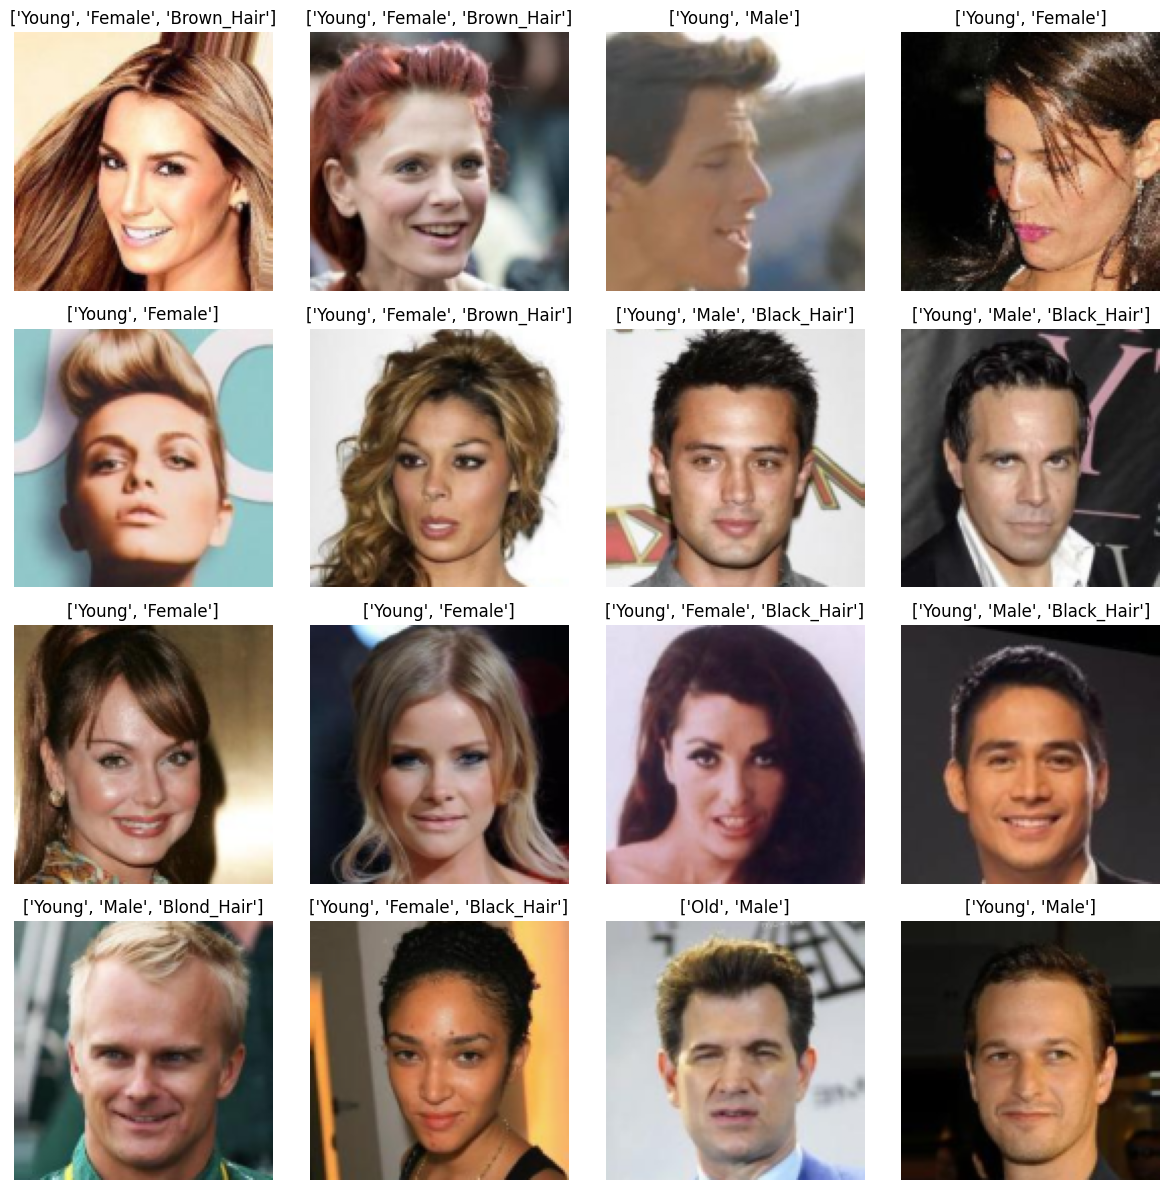

In [37]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        image = images[i] * 0.5 + 0.5
        image = image.permute(1, 2, 0).numpy()
        label = labels[i].numpy().tolist()
        label_names = [selected_attrs[i] for i, l_value in enumerate(label) if l_value == 1]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(label_names)
    plt.tight_layout()
    plt.show()

images, labels = zip(*[dataset[i] for i in range(16)])
plot_images(images, labels)

In [38]:
value_counts = np.zeros(len(selected_attrs))

for label in dataset.labels:
    value_counts += label

print(value_counts)

[ 45865. 156734. 118165.  84434.  48472.  29983.  41572.]


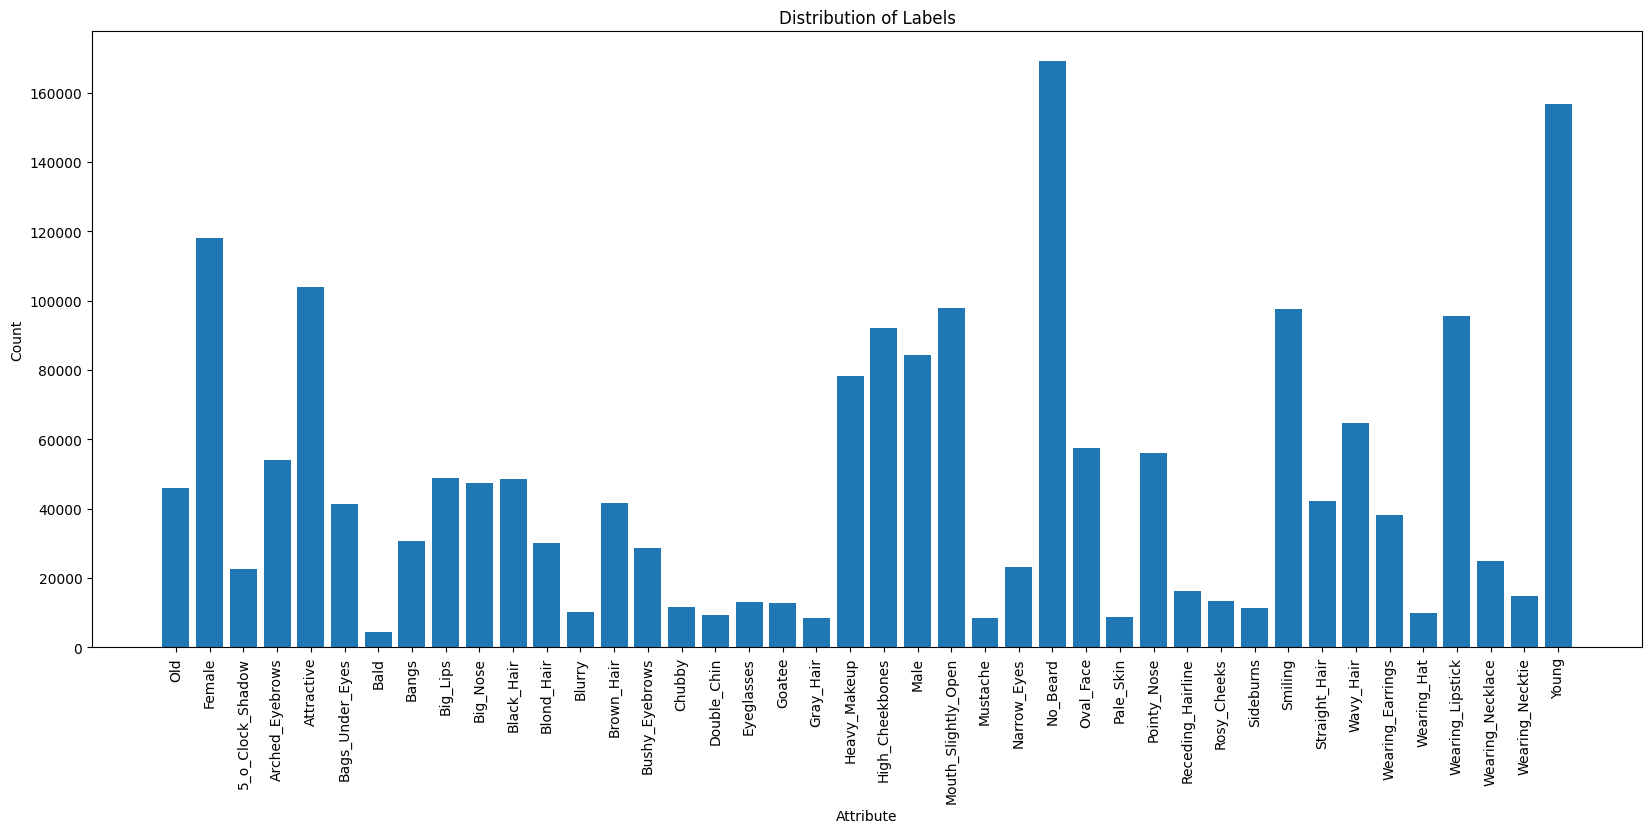

In [14]:
plt.figure(figsize=(20, 8))
plt.bar(range(len(value_counts)), value_counts)
plt.xticks(range(len(value_counts)), [selected_attrs[idx] for idx in selected_attrs.keys()], rotation=90)
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [15]:
selected_attrs_over_40000 = {attr: selected_attrs[attr] for attr in selected_attrs if value_counts[attr2idx[attr]] > 40000}
print(selected_attrs_over_40000)

{-2: 'Old', -1: 'Female', 1: 'Arched_Eyebrows', 2: 'Attractive', 3: 'Bags_Under_Eyes', 6: 'Big_Lips', 7: 'Big_Nose', 8: 'Black_Hair', 11: 'Brown_Hair', 18: 'Heavy_Makeup', 19: 'High_Cheekbones', 20: 'Male', 21: 'Mouth_Slightly_Open', 24: 'No_Beard', 25: 'Oval_Face', 27: 'Pointy_Nose', 31: 'Smiling', 32: 'Straight_Hair', 33: 'Wavy_Hair', 36: 'Wearing_Lipstick', 39: 'Young'}


In [39]:
from itertools import product
import random

def generate_valid_permutations(input_tensor, selected):
    # Define the attribute groups based on constraints
    age_attributes = ['Old', 'Young']
    gender_attributes = ['Male', 'Female']
    hair_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    
    # Map attribute names to their tensor indices
    attr_to_index = {attr: idx for idx, attr in enumerate(selected)}
    
    valid_permutations = []
    
    # Iterate over all possible combinations within each group
    for age, gender, hair in product(age_attributes, gender_attributes, hair_attributes):
        # Initialize a tensor with zeros
        perm = torch.zeros_like(input_tensor)
        
        # Set the age attribute
        if age == 'Old':
            perm[attr_to_index['Old']] = 1.0
            perm[attr_to_index['Young']] = 0.0
        else:
            perm[attr_to_index['Young']] = 1.0
            perm[attr_to_index['Old']] = 0.0
        
        # Set the gender attribute
        if gender == 'Male':
            perm[attr_to_index['Male']] = 1.0
            perm[attr_to_index['Female']] = 0.0
        else:
            perm[attr_to_index['Female']] = 1.0
            perm[attr_to_index['Male']] = 0.0
        
        # Set the hair color attribute
        perm[attr_to_index[hair]] = 1.0
        # Ensure other hair colors are set to 0
        for other_hair in hair_attributes:
            if other_hair != hair:
                perm[attr_to_index[other_hair]] = 0.0
        
        valid_permutations.append(perm)
    
    return valid_permutations


def generate_one_valid_permutation(input_tensor: torch.Tensor, selected: list) -> torch.Tensor:
    age_attributes = ['Old', 'Young']
    gender_attributes = ['Male', 'Female']
    hair_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    attr_to_index = {attr: idx for idx, attr in enumerate(selected)}

    # Randomly choose one attribute from each group
    chosen_age = random.choice(age_attributes)
    chosen_gender = random.choice(gender_attributes)
    chosen_hair = random.choice(hair_attributes)

    perm = torch.zeros_like(input_tensor)
    perm[attr_to_index[chosen_age]] = 1.0
    perm[attr_to_index[chosen_gender]] = 1.0
    perm[attr_to_index[chosen_hair]] = 1.0

    return perm

def generate_one_valid_permutation_batch(batch_tensor: torch.Tensor, selected: list) -> torch.Tensor:

    age_attributes = ['Old', 'Young']
    gender_attributes = ['Male', 'Female']
    hair_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    attr_to_index = {attr: idx for idx, attr in enumerate(selected)}
    batch_size = batch_tensor.size(0)
    num_attributes = len(selected)

    perm_batch = torch.zeros((batch_size, num_attributes), dtype=batch_tensor.dtype, device=batch_tensor.device)

    def select_attributes(group_attributes):
        num_options = len(group_attributes)
        chosen_indices = torch.randint(
            low=0, high=num_options, size=(batch_size,)
        )  # Randomly choose indices: shape (batch_size,)
        selected_attrs = [group_attributes[idx] for idx in chosen_indices.tolist()]
        return selected_attrs

    # Select one attribute from each group for all samples
    chosen_ages = select_attributes(age_attributes)
    chosen_genders = select_attributes(gender_attributes)
    chosen_hairs = select_attributes(hair_attributes)

    # Set the chosen age attributes
    age_indices = [attr_to_index[age] for age in chosen_ages]
    perm_batch[torch.arange(batch_size), age_indices] = 1.0

    # Set the chosen gender attributes
    gender_indices = [attr_to_index[gender] for gender in chosen_genders]
    perm_batch[torch.arange(batch_size), gender_indices] = 1.0

    # Set the chosen hair color attributes
    hair_indices = [attr_to_index[hair] for hair in chosen_hairs]
    perm_batch[torch.arange(batch_size), hair_indices] = 1.0

    return perm_batch

In [40]:
batched_labels = torch.stack(labels)
print(batched_labels.size())

torch.Size([16, 7])


In [41]:
c_trg = generate_one_valid_permutation_batch(batched_labels, selected_attrs)
print(*zip(c_trg, batched_labels))

(tensor([0., 1., 1., 0., 1., 0., 0.]), tensor([0., 1., 1., 0., 0., 0., 1.])) (tensor([0., 1., 0., 1., 0., 0., 1.]), tensor([0., 1., 1., 0., 0., 0., 1.])) (tensor([1., 0., 1., 0., 0., 1., 0.]), tensor([0., 1., 0., 1., 0., 0., 0.])) (tensor([0., 1., 0., 1., 0., 1., 0.]), tensor([0., 1., 1., 0., 0., 0., 0.])) (tensor([1., 0., 0., 1., 1., 0., 0.]), tensor([0., 1., 1., 0., 0., 0., 0.])) (tensor([0., 1., 0., 1., 0., 1., 0.]), tensor([0., 1., 1., 0., 0., 0., 1.])) (tensor([1., 0., 0., 1., 1., 0., 0.]), tensor([0., 1., 0., 1., 1., 0., 0.])) (tensor([1., 0., 1., 0., 1., 0., 0.]), tensor([0., 1., 0., 1., 1., 0., 0.])) (tensor([1., 0., 1., 0., 0., 0., 1.]), tensor([0., 1., 1., 0., 0., 0., 0.])) (tensor([1., 0., 0., 1., 0., 0., 1.]), tensor([0., 1., 1., 0., 0., 0., 0.])) (tensor([1., 0., 1., 0., 1., 0., 0.]), tensor([0., 1., 1., 0., 1., 0., 0.])) (tensor([1., 0., 1., 0., 0., 1., 0.]), tensor([0., 1., 0., 1., 1., 0., 0.])) (tensor([1., 0., 1., 0., 0., 0., 1.]), tensor([0., 1., 0., 1., 0., 1., 0.]))

In [42]:
label_org = labels[0]
print(selected_attrs)
c_trg_list = generate_valid_permutations(label_org, selected_attrs)
print(label_org)
print(c_trg_list)

['Old', 'Young', 'Female', 'Male', 'Black_Hair', 'Blond_Hair', 'Brown_Hair']
tensor([0., 1., 1., 0., 0., 0., 1.])
[tensor([1., 0., 0., 1., 1., 0., 0.]), tensor([1., 0., 0., 1., 0., 1., 0.]), tensor([1., 0., 0., 1., 0., 0., 1.]), tensor([1., 0., 1., 0., 1., 0., 0.]), tensor([1., 0., 1., 0., 0., 1., 0.]), tensor([1., 0., 1., 0., 0., 0., 1.]), tensor([0., 1., 0., 1., 1., 0., 0.]), tensor([0., 1., 0., 1., 0., 1., 0.]), tensor([0., 1., 0., 1., 0., 0., 1.]), tensor([0., 1., 1., 0., 1., 0., 0.]), tensor([0., 1., 1., 0., 0., 1., 0.]), tensor([0., 1., 1., 0., 0., 0., 1.])]
